In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

import warnings
warnings.filterwarnings(action='ignore')

2024-03-29 18:15:03.856000: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-29 18:15:03.980708: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-29 18:15:04.453738: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-29 18:15:06.587314: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
num_of_series = 24
ts_len = 1000
n_past = 10
n_future = 1

## Создание синтетического временного ряда

In [8]:
def sine_ts(n_points, num_of_series, dimension=1, n_periods=4, ampl=10, period_ratio=1/5):
    '''
        Данная функция создает набор из num_of_series временных рядов размера n_points. 
        Временные ряды представляют собой отличающиеся по амплитуде и фазе синусы. 
        Получаемый набор имеет высокую попарную корреляцию.
    '''
    sigma = ampl / 10
    time = np.arange(1, n_points+1)
    series_sines = []
    for i in range(1, num_of_series + 1):
        series = (ampl / 2 * i / 5) * np.sin(2 * np.pi * n_periods * time / n_points + i * 2 * np.pi / num_of_series).reshape(-1, 1)
        series_sines.append(series)
    data = np.hstack(series_sines) + sigma * np.random.randn(n_points, num_of_series)
    column_names = [f'Sine_{i}' for i in range(num_of_series)]
    ts = pd.DataFrame(data, index=time, columns=column_names)
    return ts

In [9]:
ts = sine_ts(ts_len, num_of_series)

In [10]:
def scalling(ts):
    '''
        Данная функция переводит значения набора временных рядов в интервал (-1, 1). 
        Возвращает отмасштабированный ряд и словарь скаллеров для дальнейшего обратного преобразования.
    '''
    scalled_ts = ts
    scalers = {}
    for i in ts.columns:
        scaler = MinMaxScaler(feature_range=(-1,1))
        s_s = scaler.fit_transform(scalled_ts[i].values.reshape(-1,1))
        s_s = np.reshape(s_s,len(s_s))
        scalers['scaler_'+ i] = scaler
        scalled_ts[i] = s_s
    return scalled_ts, scalers

In [11]:
def split_series(series, n_past, n_future):

    '''
        Данная функция по параметрам:
            n_past - количество прошлых значений, используемых для прогноза следующих значений,
            n_future - количество прогнозируемых значений,
        разбивает временной ряд на пары (X, y), для дальнейшего обучения модели. 
        X - вход, предыдущие n_past значений набора временного ряда. 
        y - выход, следующие n_future значений временного ряда.
    '''
    
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
              break
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [12]:
def get_split_series(train_ts, test_ts, n_past, num_of_series, n_future=1):
    X_train, y_train = split_series(train_ts.values,n_past, n_future)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], num_of_series))
    y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], num_of_series))
    X_test, y_test = split_series(test_ts.values,n_past, n_future)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], num_of_series))
    y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], num_of_series))
    return X_train, y_train, X_test, y_test

In [13]:
def get_e2d2_model(n_past, num_of_series, n_future=1):
    encoder_inputs = tf.keras.layers.Input(shape=(n_past, num_of_series))
    encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)
    encoder_states1 = encoder_outputs1[1:]
    encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
    encoder_outputs2 = encoder_l2(encoder_outputs1[0])
    encoder_states2 = encoder_outputs2[1:]
    
    decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
    
    decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
    decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_of_series))(decoder_l2)
    
    model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)

    return model_e2d2

In [14]:
def train_model(model, X_train, y_train, X_test, y_test, reduce_lr, epochs=10, batch_size=32):
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
    history = model.fit(X_train,y_train,epochs=epochs,validation_data=(X_test,y_test),batch_size=batch_size,verbose=0,callbacks=[reduce_lr])
    forecast = model.predict(X_test)
    return forecast

In [15]:
def inverse_scalling(columns, scalers, ts):
    for index, i in enumerate(columns):
        scaler = scalers['scaler_'+i]
        ts[:, :, index] = scaler.inverse_transform(ts[:,:,index])
    return ts

In [16]:
def forecast(ts, n_past, num_of_series, train_test_ratio=0.7):
    split_point = int(ts.shape[0] * train_test_ratio)
    train_ts, test_ts = ts[1:split_point], ts[split_point:]

    train, scallers_train = scalling(train_ts)
    test, scallers_test = scalling(test_ts)
    
    X_train, y_train, X_test, y_test = get_split_series(train, test, n_past, num_of_series)

    model_e2d2 = get_e2d2_model(n_past, num_of_series)
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
    pred_e2d2 = train_model(model_e2d2, X_train, y_train, X_test, y_test, reduce_lr)

    pred_e2d2 = inverse_scalling(train_ts.columns, scallers_test, pred_e2d2)
    y_train = inverse_scalling(train_ts.columns, scallers_train, y_train)
    y_test = inverse_scalling(train_ts.columns, scallers_test, y_test)

    pred_e2d2 = pd.DataFrame(pred_e2d2.reshape(ts.shape[0] - split_point - n_past, num_of_series))  
    y_test = pd.DataFrame(y_test.reshape(ts.shape[0] - split_point - n_past, num_of_series)) 

    return pred_e2d2, y_test

In [17]:
def MAPE_MSE_avg(forecast_ts, test_ts, num_of_series):
    sum_mape = 0
    sum_mse = 0
    for i in range(num_of_series):
        ytrue = test_ts.iloc[:, i].values
        yhat = forecast_ts.iloc[:, i].values
        mae = MAE(ytrue, yhat)
        mse = MSE(ytrue, yhat)
        sum_mape += mae
        sum_mse += mse
    return sum_mape / num_of_series, sum_mse / num_of_series

In [18]:
def accuracy_vs_ts_num(ts):
    num_of_series = ts.shape[1]
    mape_num_of_series = []
    mse_num_of_series = []

    for i in range(1, num_of_series + 1):

        ts_slice = ts.iloc[:, :i]
        forecast_ts, actual_ts = forecast(ts, n_past, num_of_series)
        avg_mape, avg_mse = MAPE_MSE_avg(forecast_ts, actual_ts, num_of_series)
        mape_num_of_series.append(avg_mape)
        mse_num_of_series.append(avg_mse)

    return mape_num_of_series, mse_num_of_series

## Прогнозирования набора высококоррелируемых синусов 

<Axes: >

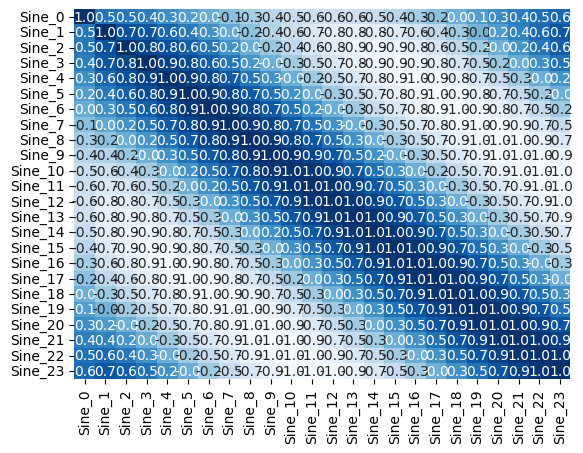

In [14]:
sns.heatmap(ts.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')

In [39]:
forecast_df, actual_df = forecast(ts, n_past, num_of_series)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


In [40]:
Mape_avg, MSE_avg = MAPE_MSE_avg(forecast_df, actual_df, num_of_series)
print(Mape_avg, MSE_avg)

0.9360669767065427 1.3565894317719611


In [41]:
split_point = 700
forecast_df = forecast_df.set_index(forecast_df.index + split_point + 10)

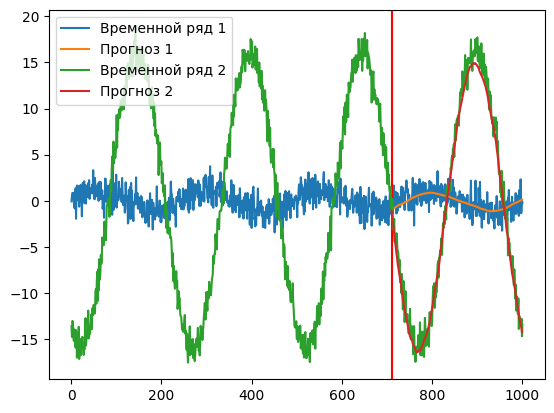

In [43]:
plt.plot(ts.iloc[:, 0], label="Временной ряд 1")
plt.plot(forecast_df.iloc[:, 0], label="Прогноз 1")
plt.axvline(x = split_point + 10, color='r')

plt.plot(ts.iloc[:, 15], label="Временной ряд 2")
plt.plot(forecast_df.iloc[:, 15], label="Прогноз 2")

plt.legend()
plt.savefig("fig_sines")

In [20]:
for i in range(num_of_series):
    ytrue = actual_df.iloc[:, i].values
    yhat = forecast_df.iloc[:, i].values
    mape = MAPE(ytrue, yhat)
    mse = MSE(ytrue, yhat)
    print(f"{i}: MAPE = {mape}, MSE = {mse}")

0: MAPE = 1.7370819018705694, MSE = 0.9876994777661974
1: MAPE = 1.5949831448723881, MSE = 0.954674567857903
2: MAPE = 1.5196482037767733, MSE = 1.2230434574998796
3: MAPE = 0.8520453862344339, MSE = 0.927286879955102
4: MAPE = 0.9048836393531265, MSE = 1.5357930468283405
5: MAPE = 0.47576716466739405, MSE = 1.4242122612075374
6: MAPE = 0.7817653732011084, MSE = 1.5851764600044465
7: MAPE = 0.5733442332092691, MSE = 1.799773357841726
8: MAPE = 0.2836209939273507, MSE = 1.0860009690444075
9: MAPE = 0.24255783984786028, MSE = 0.8882892343528561
10: MAPE = 0.2868911163543322, MSE = 1.1979212480249384
11: MAPE = 0.2897192642099974, MSE = 1.0173317308282843
12: MAPE = 4.2963494878204775, MSE = 1.3672814773392936
13: MAPE = 0.30603233619305203, MSE = 1.238693540435143
14: MAPE = 0.9111355604773488, MSE = 1.8435476152342265
15: MAPE = 0.33322503041809104, MSE = 1.1549703523651251
16: MAPE = 0.22870952817312273, MSE = 1.1393460930296764
17: MAPE = 0.20280047226618214, MSE = 0.9891437911728448


## Прогнозирование реального набра временных рядов: Цены на электричество.

In [41]:
colnames = ['Time'] + [f'Price{i}' for i in range(24)]

df = pd.read_csv('Погружение временных рядов с высокой волатильностью в метрическое пространство/Данные/GermanSpotPrice.csv', names=colnames, header=None)
df = df.set_index('Time')
df = df.set_index(df.index - 731582)

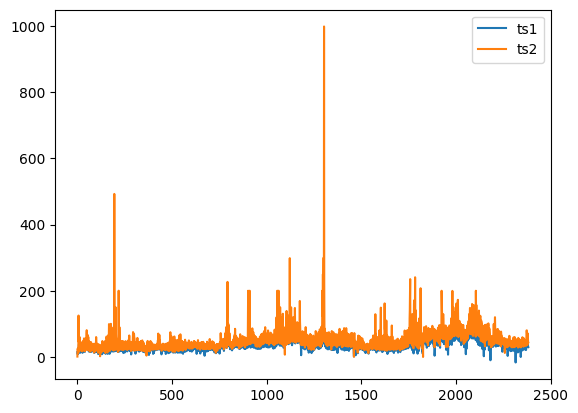

In [4]:
plt.plot(df.iloc[:, 0], label='ts1')
plt.plot(df.iloc[:, 10], label='ts2')
plt.legend()

<Axes: >

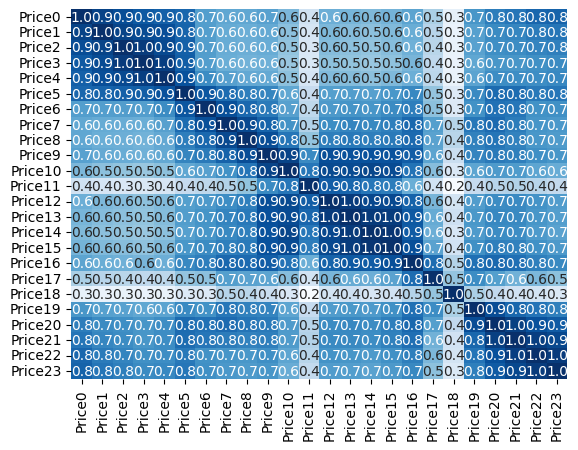

In [5]:
sns.heatmap(df.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')

In [42]:
num_of_series = df.shape[1]

In [19]:
forecast_df, actual_df = forecast(df, n_past, num_of_series)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


In [20]:
train_test_ratio = 0.7
split_point = int(df.shape[0] * train_test_ratio)
forecast_df = forecast_df.set_index(forecast_df.index + split_point + 10)

In [21]:
forecast_df.head()
forecast_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
2378,21.838428,-60.917629,-24.071293,-12.498881,-20.239067,19.448706,-64.660713,-22.914837,57.952545,18.436691,...,27.565104,30.870686,25.610622,69.419968,82.714035,57.244125,50.495632,48.235687,38.464504,41.082191
2379,24.084585,-54.263763,-18.899721,-6.935257,-14.439312,22.228809,-57.027107,-17.667727,64.430641,20.685705,...,28.753473,32.169495,28.321310,73.180168,85.111595,60.015354,53.357094,50.318844,40.137527,42.625130
2380,21.107964,-63.812523,-26.235182,-15.233531,-22.789349,18.453609,-67.967606,-26.715569,54.148991,16.821386,...,26.491884,30.537859,23.070026,62.879642,83.895821,55.694878,49.586697,47.267887,38.012966,40.671993
2381,20.127851,-67.166603,-29.257210,-18.641060,-25.719995,17.538595,-70.248055,-28.585321,51.348392,16.062416,...,25.993248,30.418083,22.072998,59.371426,82.732727,54.323887,49.073780,46.780910,37.389225,40.199108
2382,19.709293,-67.806427,-29.978886,-19.430813,-26.218407,17.513372,-70.278290,-28.780174,50.807800,15.623359,...,25.716030,29.714743,21.627508,58.652004,80.636261,53.770763,48.784542,46.547634,36.891758,39.794155


In [22]:
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE

for i in range(num_of_series):
    ytrue = actual_df.iloc[:, i].values
    yhat = forecast_df.iloc[:, i].values
    mae = MAE(ytrue, yhat)
    mse = MSE(ytrue, yhat)
    print(f"{i}: MAE = {mae}, MSE = {mse}")

0: MAE = 11.695247590923985, MSE = 176.02173049182286
1: MAE = 76.69883495165016, MSE = 6180.116114447652
2: MAE = 43.70662129796841, MSE = 2041.5281955643177
3: MAE = 27.977912975561534, MSE = 967.9275263153031
4: MAE = 33.889007740494634, MSE = 1321.3436496503325
5: MAE = 10.39114281864031, MSE = 147.74253804410742
6: MAE = 81.50952836043582, MSE = 7087.831214807444
7: MAE = 57.855125824477234, MSE = 3946.542384344174
8: MAE = 24.890347500740216, MSE = 1143.2387658186071
9: MAE = 36.28794879613024, MSE = 1777.129318065737
10: MAE = 40.626656364332696, MSE = 2230.8410634394268
11: MAE = 29.74400122210996, MSE = 1648.9804962705005
12: MAE = 23.545084612582592, MSE = 890.8660503312642
13: MAE = 23.459970623476284, MSE = 898.2892071342309
14: MAE = 30.969134360888322, MSE = 1471.576016362691
15: MAE = 24.63574308073436, MSE = 970.1911094037258
16: MAE = 19.97596533457438, MSE = 653.0766633144054
17: MAE = 44.489608022270474, MSE = 3687.117802422561
18: MAE = 32.362873522819356, MSE = 204

In [23]:
variance = df.var()
print(variance)

Price0      175.697432
Price1      176.406475
Price2      156.286085
Price3      144.061162
Price4      146.672124
Price5      167.711770
Price6      333.304754
Price7      768.170080
Price8      906.470151
Price9      992.796372
Price10    1398.560567
Price11    3770.898680
Price12    1043.802822
Price13     986.098691
Price14     978.303597
Price15     794.142965
Price16     645.306795
Price17    1547.694608
Price18    5097.760220
Price19     713.736112
Price20     432.749149
Price21     273.213084
Price22     232.841038
Price23     164.097999
dtype: float64


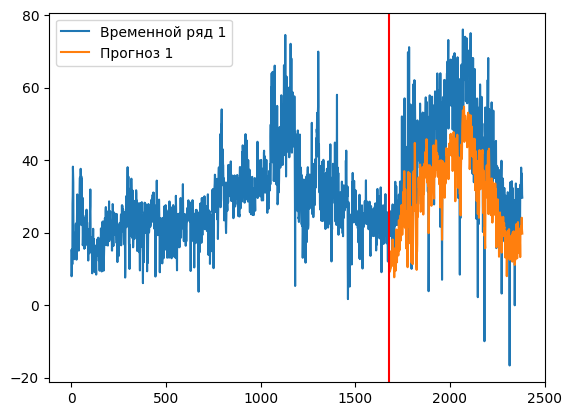

In [24]:
plt.plot(df.iloc[:, 0], label="Временной ряд 1")
plt.plot(forecast_df.iloc[:, 0], label="Прогноз 1")
plt.axvline(x = split_point + 10, color='r')
plt.legend()

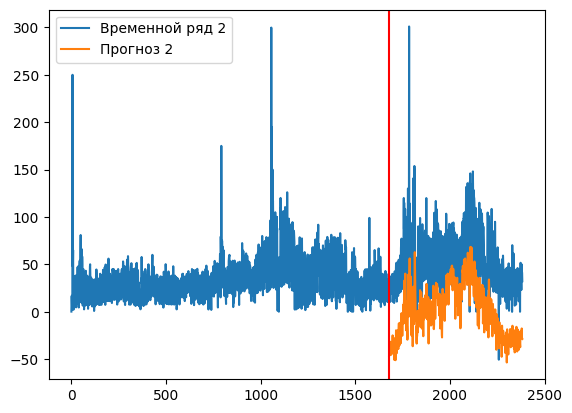

In [25]:
plt.plot(df.iloc[:, 7], label="Временной ряд 2")
plt.plot(forecast_df.iloc[:, 7], label="Прогноз 2")
plt.axvline(x = split_point + 10, color='r')
plt.legend()

In [26]:
Mape_avg, MSE_avg = MAPE_MSE_avg(forecast_df, actual_df, num_of_series)
print(Mape_avg, MSE_avg)

30.23550170799406 1679.485569865649


### Определим количество временных рядов из набора, которые разумно прогнозировать.

In [72]:
number_of_ts_vs_MSE = []
number_of_ts_vs_MAE = []
shuffled_column_names = []
num_of_shuffles = 10

In [73]:
for i in range(num_of_shuffles):
    shuffled_df = df.sample(frac=1, axis=1)
    shuffled_column_names.append(shuffled_df.columns)
    mae, mse = accuracy_vs_ts_num(shuffled_df)
    number_of_ts_vs_MSE.append(mse)
    number_of_ts_vs_MAE.append(mae)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [74]:
number_of_ts_forecasting = [i for i in range(1, 25)]

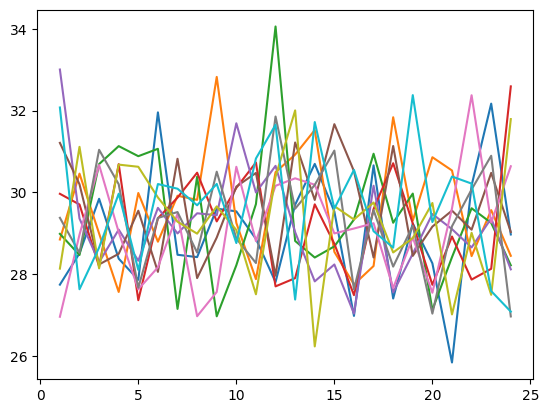

In [75]:
for x in number_of_ts_vs_MAE:
    plt.plot(number_of_ts_forecasting, x)

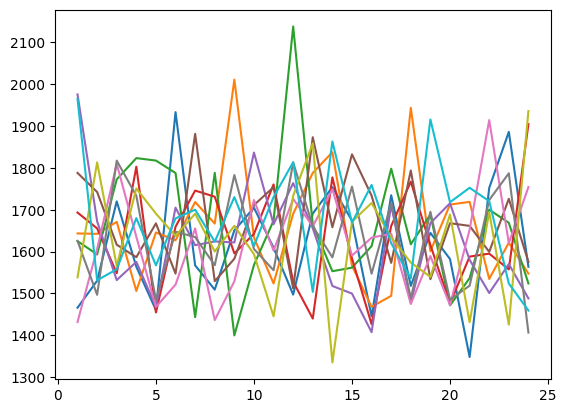

In [76]:
for x in number_of_ts_vs_MSE:
    plt.plot(number_of_ts_forecasting, x)

In [77]:
difference = []

for i in range(num_of_shuffles):
    difference.append([0])
    for j in range(1, 24):
        difference[i].append(number_of_ts_vs_MAE[i][j] - number_of_ts_vs_MAE[i][j - 1])

In [84]:
keys = list(df.columns)
my_dict = {key: [] for key in keys}

In [85]:
for i in range(10):
    for j in range(24):
        if difference[i][j] != 0:
            my_dict[shuffled_column_names[i][j]].append(difference[i][j])

In [86]:
print(my_dict)

{'Price0': [-1.0561203735133944, 2.614576764936885, -1.6868270388122042, 2.1031929760244914, -0.7606915255261875, 0.3335680591014629, 1.7036621211480494, 2.5204256121749964, 3.4295760744958272, 1.1129939607765635], 'Price1': [0.7661133186963411, -1.3741925303786076, 1.248077807653008, 2.001938280063669, 0.7104230999843573, -1.4043109984718605, 0.5933904566995558, -2.253544538899238, -2.9709353481742973, 0.9462308233507954], 'Price2': [-1.4633531386165721, -2.9771993266618324, 0.43919589231612477, 2.4986914742196724, 0.6505218599338036, 3.2557567979012774, 2.060764792270078, 0.1435106566807356, -0.5783778967992959, 1.0188327747379873], 'Price3': [-0.9732614483178033, -1.1905358719367598, 4.341326941565647, -1.2551250437109225, -0.4481368964506167, 1.053049137347294, 0.18292606616312312, 0.5813141999993867, 0.857774218076635, -2.626843184369605], 'Price4': [-2.4241800298200893, 0.4284932700363129, 1.4956911646069777, 0.5063643406714782, 0.7968447798094545, 2.764654221196473, -1.351273301

In [87]:
mean_values = {key: np.mean(value) for key, value in my_dict.items()}

In [88]:
print(mean_values)

{'Price0': 1.031435663080649, 'Price1': -0.17368096294762764, 'Price2': 0.5048343885981978, 'Price3': 0.0522488118366379, 'Price4': 0.3751033096714895, 'Price5': -0.5369105478454486, 'Price6': -0.7251592746072415, 'Price7': 0.3953290439642608, 'Price8': 0.28196740176283364, 'Price9': 0.005169369696608328, 'Price10': -0.5068118424465946, 'Price11': 0.2139766239139295, 'Price12': 0.13588376264079755, 'Price13': 0.2697776706351287, 'Price14': 0.4274514203365598, 'Price15': 0.7003792236710737, 'Price16': -1.0151690475163855, 'Price17': -0.9602855682655833, 'Price18': 0.7841289678664765, 'Price19': -1.2159287914634374, 'Price20': -0.00046179247940472126, 'Price21': 0.7748561581197061, 'Price22': -1.0979370623244251, 'Price23': -0.3616845030157399}


In [89]:
avg_mae_vs_num_ts = []

In [90]:
for i in range(24):
    sum_ = 0
    for j in range(10):
        sum_ += number_of_ts_vs_MAE[j][i]
    avg_mae_vs_num_ts.append(sum_ / 10)

In [91]:
print(avg_mae_vs_num_ts)

[29.631548506275276, 29.294388425285653, 29.276779932034277, 29.523853819467906, 28.801952076719097, 29.649165405910043, 29.361610100958593, 29.068061738780074, 29.49693265103022, 29.63000643047028, 29.308948180699332, 30.27339762926721, 29.692337222080944, 29.63083121075751, 29.47025025238379, 28.575086610763314, 29.55927063883335, 29.093789249150188, 29.406014947228005, 28.623619375516235, 28.85649665312087, 29.55171846063838, 29.421392820914853, 29.187155035770036]


(20.0, 40.0)

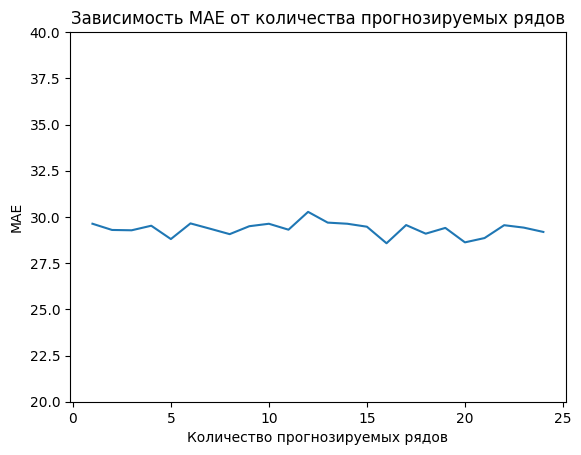

In [95]:
plt.plot(number_of_ts_forecasting, avg_mae_vs_num_ts)
plt.xlabel("Количество прогнозируемых рядов")
plt.ylabel("MAE")
plt.title("Зависимость MAE от количества прогнозируемых рядов")
plt.ylim(20, 40)